Authors: Timothy Hochberg <tim@skytruth.org>, Egil Möller <egil@skytruth.org>

Model Descriptions
------------------


## Heuristic Model

The first model developed is referred to as the
*heuristic model* and was derived by observing that there were
correlations between fishing behaviour and several of the
values present in AIS messages. In particular, the
likelihood that a vessel was fishing tends to increase with
the standard deviation of the speed and course, but to decrease
with mean speed. These features were used to develop the 
*heursitic model*:

$$
fishing\_score = \frac{2}{3}\left(\sigma_{s_m} + \sigma_{c_m} + \overline{s_m}\right) 
$$

Here $s_m$ and $c_m$ are simple features derived from the
speed and course respectively and $\sigma_x$ and $\overline{x}$
have their standard meanings

$$
\begin{align}
s_m & \equiv 1.0 - \min\left(1, speed\,/\,17\right) \\
c_m & \equiv course\,/\,360 \\
\sigma_x & \equiv \text{standard deviation of } x \\
\overline{x} & \equiv \text{mean of } x
\end{align}
$$

For the *heuristic model*, the means and standard deviations are computed 
over a one hour window.

The heuristic model performs reasonably well trawlers and
longliners, but poorly for purse seiners.

  * Implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/legacy_heuristic_model.py
  * Normalization and calculation of $\sigma_{s_m}$, $\sigma_{c_m}$, $\overline{s_m}$
    (note that $s_m$ and $c_m$ are referred to as `measure_speed` and `measure_course`
    in the code): 
    https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/add_measures.py


## Generic Model

A series of logistic regression models were then developed
using the same three features found in the *heursitic
model*. In order to increase the expressiveness of the
logistic model, powers of the 3 base features are added to
the features. Thus, the full feature vector consists of:
$$
\sigma_{s_m}, \sigma_{s_m}^2,\ldots, \sigma_{s_m}^n, \sigma_{c_m}, \sigma_{c_m}^2,\ldots, \sigma_{c_m}^n,
\overline{s_m},\overline{s_m}^2, \ldots \overline{s_m}^n \\
$$
where $n$ is what we shall be refer to as the *feature order*.
Note that that despite the odd form of
$s_m$, from the point of view of the
logistic model, it is equivalent to the the speed
capped at 17 knots.

The first of the logistic models, referred to as the
*generic model*, is the model currently in use and 
is a logistic model using a 12 hour time window
and a feature order of 6. One model is trained for all gear
types. This model generally performs bettter than the
heuristic model, but still performs rather poorly on purse
seiners. The 12-hour window was arrived at by plotting the model
accuracy versus window size. There is a different optimal
window size for each gear type, but 12 hours performed
well for a model trained and tested on all gear types.

  * Implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/logistic_model.py
  * Parameters for the implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/models.py#L17
  * Normalization and calculation of $\sigma_{s_m}$, $\sigma_{c_m}$, $\overline{s_m}$
    (note that $s_m$ and $c_m$ are referred to as `measure_speed` and `measure_course`
    in the code): https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/add_measures.py


## Multi-Window Model

The multi-window model 
is a logistic model similar to the *generic model* except that
it uses
multiple time windows, ranging in duration from one-half to
twenty four hours. Using multiple window sizes both provides
a richer feature set and avoids the needs to optimize over
window size. 


* Implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/logistic_model.py
* Parameters for the implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/models.py#L20
  * Windows used: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/colspec.py#L4

## Multi-Window, Gear-Types-Specific Models

The multi-window gear-type-specific model, which 
is on the verge of being deployed, are a set of 
models, each the same as the Multi-Window model, 
but each trained on only vessels with a specific 
gear type. We have currently trained the model 
for longliners, trawlers and purse seiners. 
We are also experimenting with adding other features.
In particular, whether it is currently daylight appears to
be a very useful feature for predicting purse seine fishing.
These changes, taken together, dramatically improve the
performance, particularly of purse seiners.

* Implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/logistic_model.py
* Parameters for the implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/models.py#L22-L38

## Future Models

It is straightforward to use the multi-window logistic
model features described above with a random forest or neural net
model. In early experiments, both of these model types offer
slightly improved performance relative to logistic model while at
the same eliminating the need to augment the feature vector
with powers of the base features.

We eventually plan to experiment with using convolutional or
recurrent neural networks to find features in the AIS data
directly rather than hand engineering the features.


General Notes
-------------

The precision of the models vary by gear type: Long liners are easiest to
predict, even for a model trained on all gear types,
followed by trawlers; purse seiners are the worst.

We have evaluated the models using a separate test set (and
for window size and feature order, optimization, using
separate train-, validation- and test-sets) plotting
precision/recall and ROC curves.

We have also evaluated the generic model on each gear type
separately as well as on the combined data set. In addition,
for longliners we have cross trained and validated between
two separately labelled datasets with slightly different
labeling methods (Kristinas' and Alex data).


In [37]:
from __future__ import print_function, division
import sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import vessel_scoring.models
from vessel_scoring.models import train_model_on_data
from vessel_scoring import data, utils
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, HTML, Markdown
from sklearn import metrics
import pandas as pd

In [43]:
# Load training and test data

# Data supplied by Kristina
_, train_lline,  valid_lline, test_lline = data.load_dataset_by_vessel(
        '../datasets/kristina_longliner.measures.npz')
_, train_trawl,  valid_trawl, test_trawl = data.load_dataset_by_vessel(
        '../datasets/kristina_trawl.measures.npz')
_, train_pseine, valid_pseine, test_pseine = data.load_dataset_by_vessel(
        '../datasets/kristina_ps.measures.npz')

# Crowd sourced longliner data
test_lline_crowd, _, _, _ = data.load_dataset_by_vessel(
        "../datasets/classified-filtered.measures.npz")

# Crowd sourced data from DavidK's setup
test_lline_crowd_new, _, _, _ = data.load_dataset_by_vessel(
        "../datasets/id_fishing_points_longliner_classified_tracks.measures.npz")

test_trawler_crowd_new, _, _, _ = data.load_dataset_by_vessel(
        "../datasets/id_fishing_points_trawler_classified_tracks.measures.npz")

test_pseine_crowd_new, _, _, _ = data.load_dataset_by_vessel(
        "../datasets/id_fishing_points_purse_seine_classified_tracks.measures.npz")

# Slow transits (used to train models to avoid classifying slow transits as fishing)
TRANSIT_WEIGHT = 10
x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel(
                                    '../datasets/slow-transits.measures.npz', even_split=False)
xtrain_tran = utils.clone_subset(xtrain_tran, test_lline.dtype)
xcross_tran = utils.clone_subset(xcross_tran, test_lline.dtype)
xtest_tran = utils.clone_subset(xtest_tran, test_lline.dtype)
train_tran = np.concatenate([xtrain_tran, xcross_tran] * TRANSIT_WEIGHT)

train = np.concatenate([train_trawl, train_lline, train_pseine, 
                        valid_lline, valid_trawl, valid_pseine, train_tran])

Warning, insufficient items to sample, returning all


## How much test data do we have

Our initial test and training data consisted of roughly a dozen different vessels of each type 
classified over a multi-year period by Kristina Boerder of Dalhousie University. One-quarter of 
those are used for testing, so there is a relatively small number of different vessels in the test
sets. 

In addition, we are beginning to collect crowd sourced data for both testing and training. Some of the
early crowd sourced data, available for long liners only, is used as an additional test set in the examples
below.

In [45]:
for name, test_data in [("trawlers", test_trawl),
                        ("David crowd sourced trawlers", test_trawler_crowd_new),
                        ("purse seiners", test_pseine),
                        ("David crowd sourced purse seines", test_pseine_crowd_new),
                        ("longliners", test_lline),
                        ("Alex crowd sourced longliners", test_lline_crowd),
                        ("David crowd sourced longliners", test_lline_crowd_new)]:

    mmsi_count = len(set(test_data['mmsi']))
    pt_count = len(test_data)
    print("For {0} we have {1} test vessels with {2} test points".format(name, mmsi_count, pt_count))

For trawlers we have 3 test vessels with 5000 test points
For David crowd sourced trawlers we have 218 test vessels with 300219 test points
For purse seiners we have 3 test vessels with 5000 test points
For David crowd sourced purse seines we have 12 test vessels with 83685 test points
For longliners we have 2 test vessels with 5000 test points
For Alex crowd sourced longliners we have 118 test vessels with 324166 test points
For David crowd sourced longliners we have 70 test vessels with 325398 test points


In [46]:
# Prepare the models

from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.logistic_model import LogisticModel

uniform_training_data = {'longliner': train, 
                         'longliner crowd' : train,
                         'longliner crowd 2' : train,
                         'trawler': train, 
                         'trawler crowd 2': train,
                         'purse_seine': train,
                         'purse_seine crowd 2': train}

gear_specific_training_data = {'longliner': np.concatenate([train_lline, valid_lline, train_tran]), 
                               'longliner crowd' : np.concatenate([train_lline, valid_lline, train_tran]), 
                               'longliner crowd 2' : np.concatenate([train_lline, valid_lline, train_tran]), 
                               'trawler': np.concatenate([train_trawl, valid_trawl, train_tran]),
                               'trawler crowd 2': np.concatenate([train_trawl, valid_trawl, train_tran]),
                               'purse_seine': np.concatenate([train_pseine, valid_pseine, train_tran]),
                               'purse_seine crowd 2': np.concatenate([train_pseine, valid_pseine, train_tran])}

test_data = {'longliner': test_lline, 
             'longliner crowd': test_lline_crowd,
             'longliner crowd 2': test_lline_crowd_new,
             'trawler': test_trawl, 
             'trawler crowd 2': test_trawler_crowd_new,
             'purse_seine': test_pseine,
             'purse_seine crowd 2': test_pseine_crowd_new}

untrained_models = [
    ("Heuristic Model", LegacyHeuristicModel(window=3600), 
         uniform_training_data),
    ('Generic Model', LogisticModel(colspec=dict(windows=[43200]), order=6),
         uniform_training_data),
    ('Multi-Window, Gear-Type-Specific Models', LogisticModel(colspec=dict(
        windows=[1800, 3600, 10800, 21600, 43200, 86400],
        measures=['measure_daylight', 'measure_speed']), order=6), 
         gear_specific_training_data),
]

## Model Comparisons

The models output a numbers between 0 and 1 that correspond to how 
confident they are that there is fishing occuring. For
the first set of comparisons we treat predictions `>0.5`
as fishing and those `<=0.5` as nonfishing. This allows us to use
*precision*, *recall* and *f1-score* as metrics. We also show Receiver
Operator Characteristic (ROC) area under the curve (AUC) plots and 
precision recall plots.

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|1.00|0.06|0.11|
|Generic Model|0.46|0.06|0.10|
|Multi-Window, Gear-Type-Specific Models|0.85|0.24|0.38|

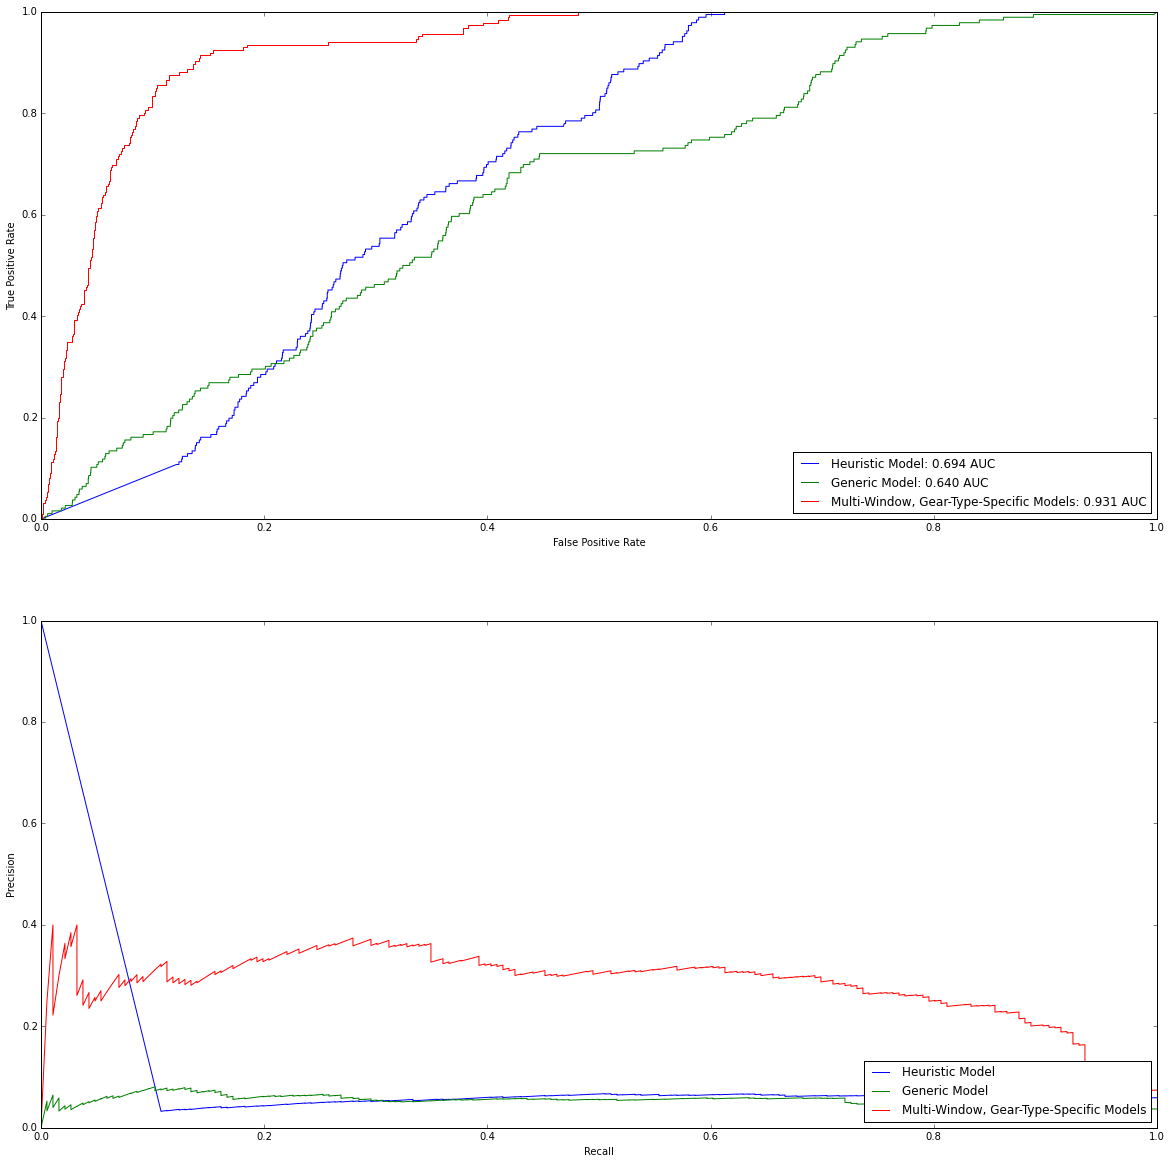

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|0.62|0.27|0.37|
|Generic Model|0.35|0.41|0.38|
|Multi-Window, Gear-Type-Specific Models|0.15|0.38|0.22|

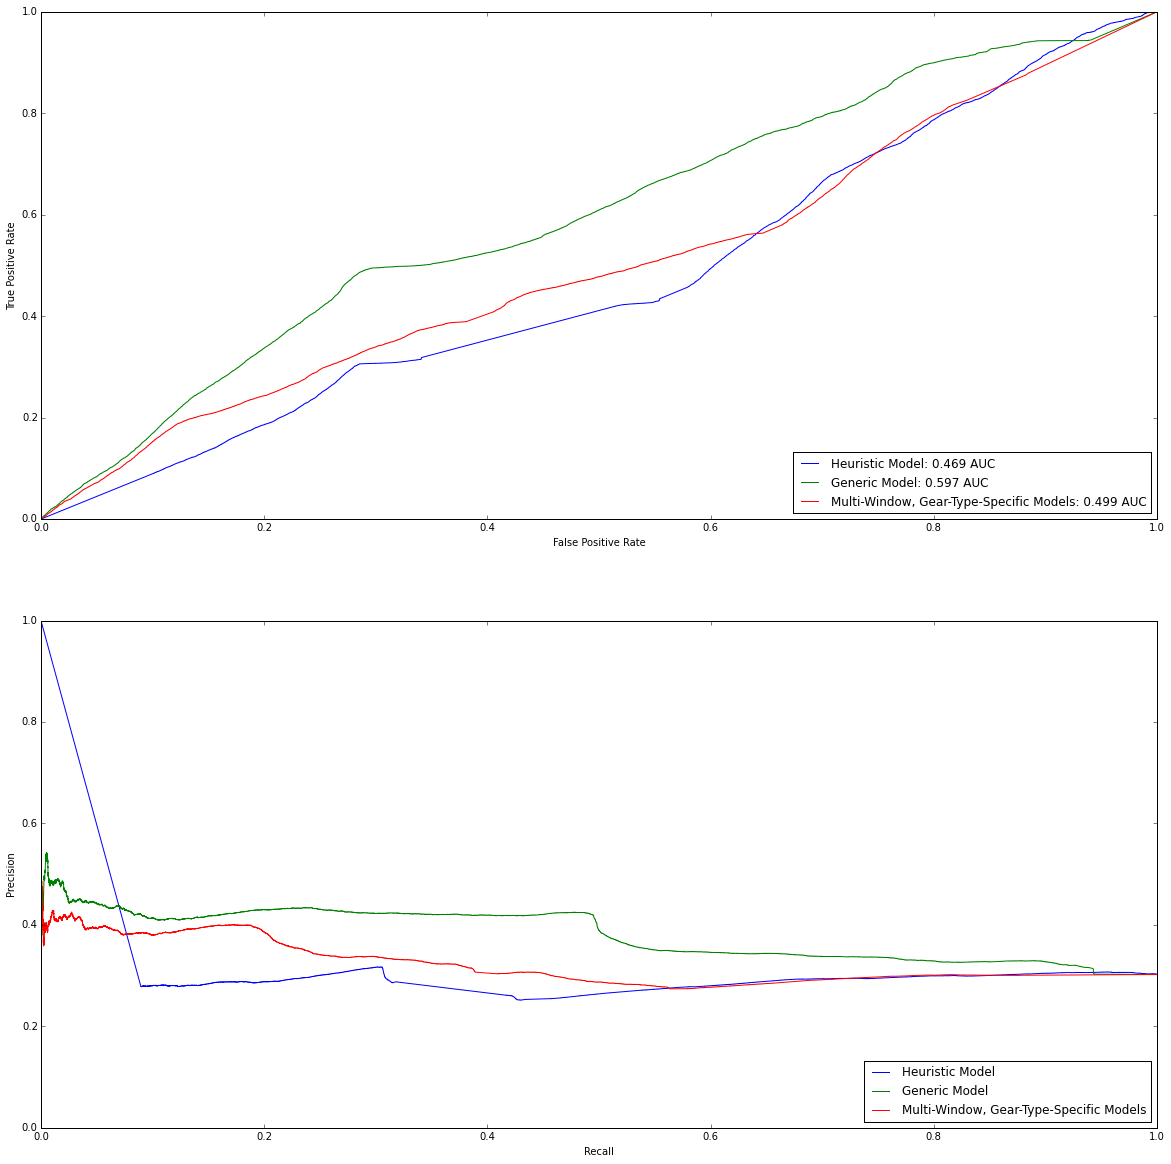

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|0.88|0.82|0.85|
|Generic Model|0.85|0.90|0.88|
|Multi-Window, Gear-Type-Specific Models|0.89|0.95|0.92|

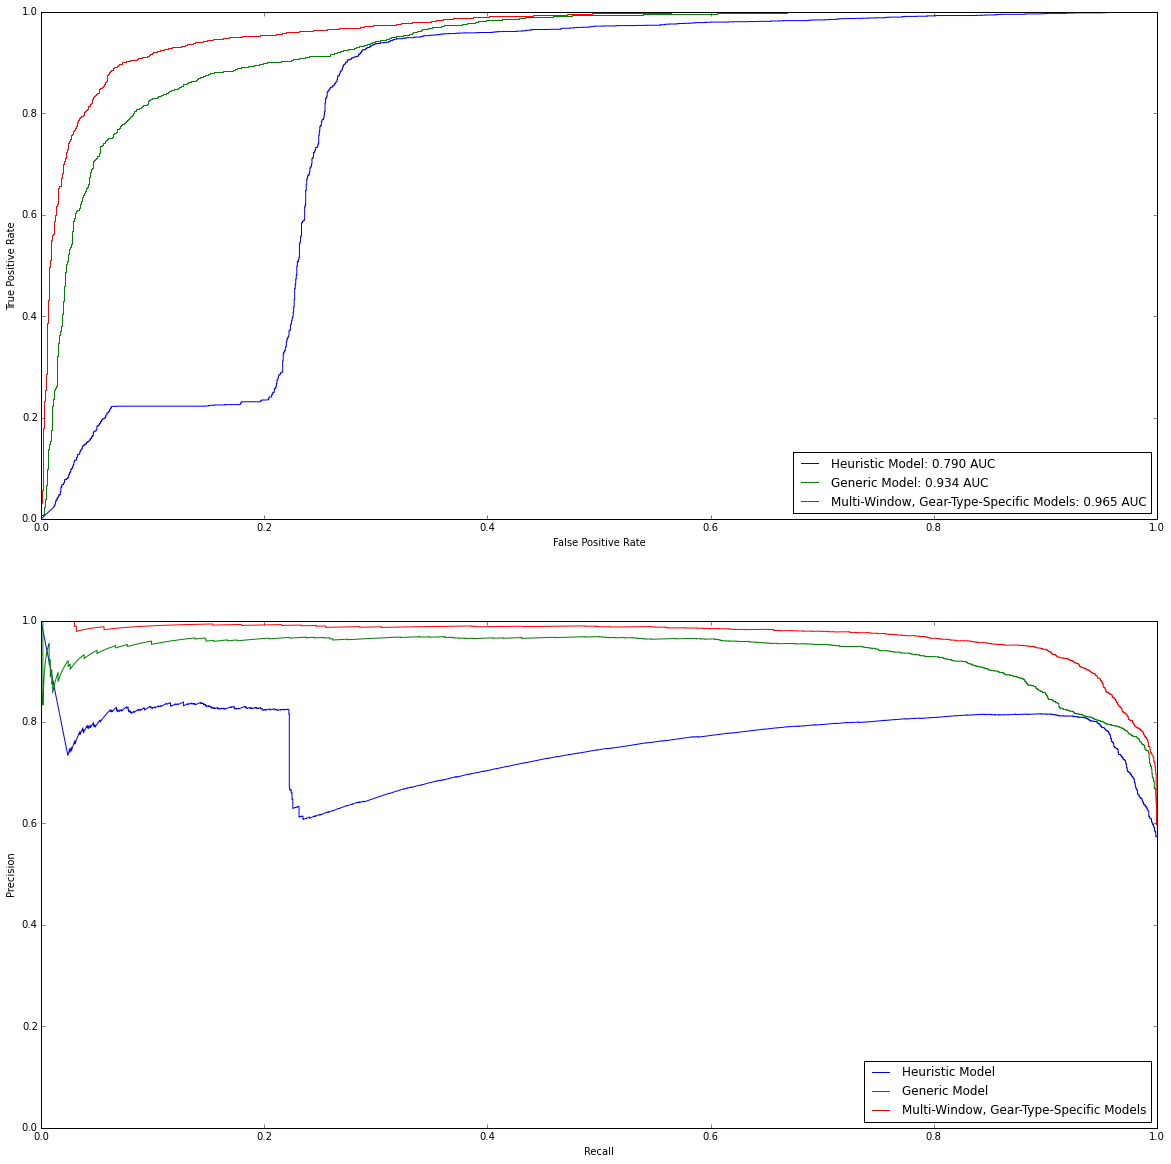

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|0.77|0.47|0.58|
|Generic Model|0.64|0.57|0.60|
|Multi-Window, Gear-Type-Specific Models|0.60|0.59|0.59|

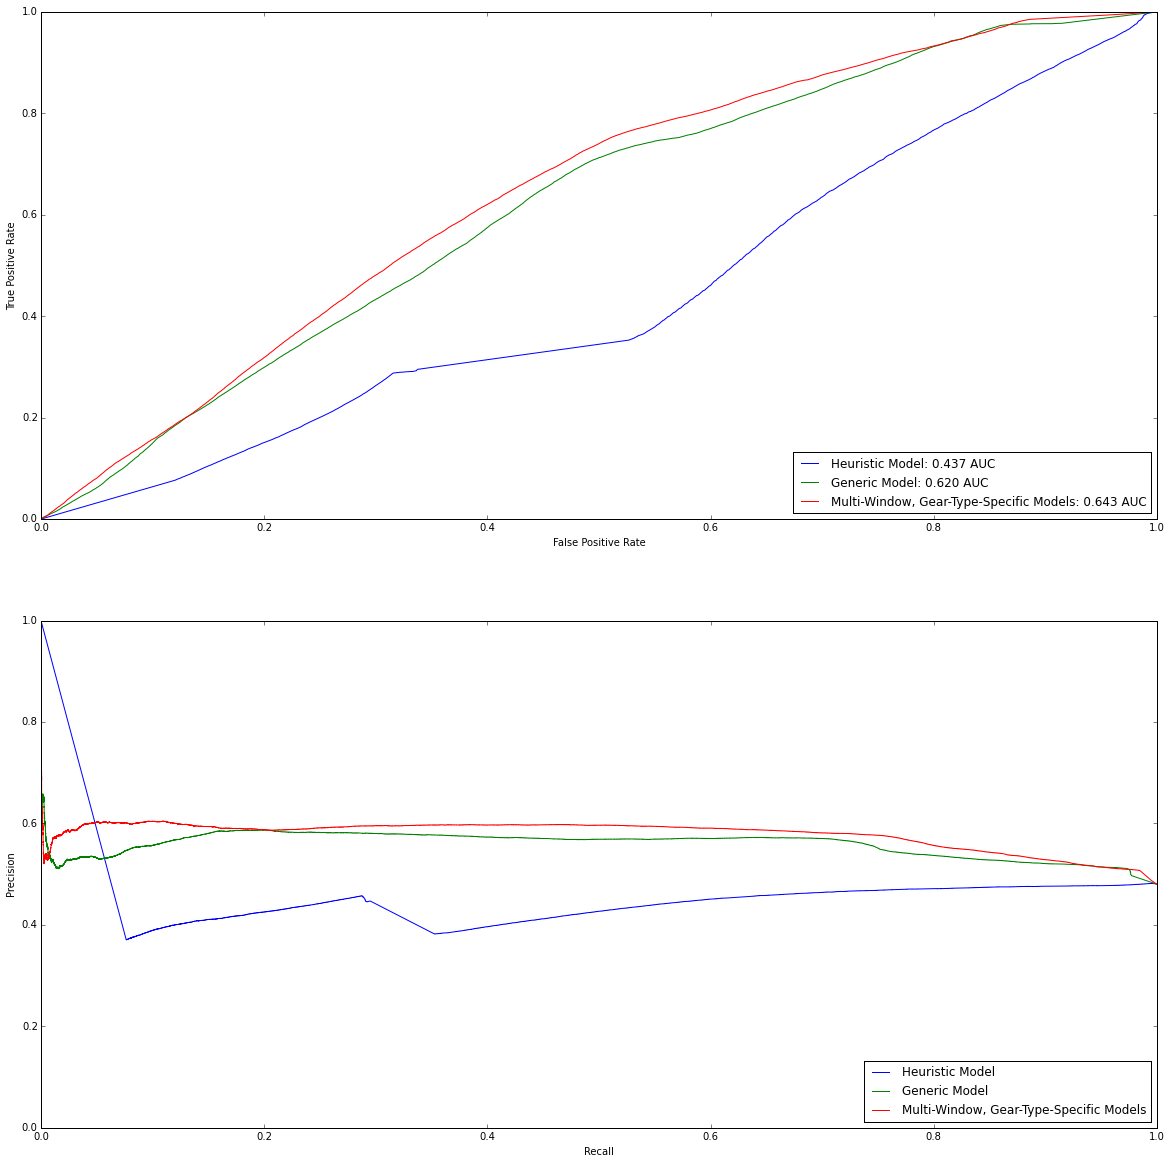

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|0.59|0.94|0.72|
|Generic Model|0.81|0.94|0.87|
|Multi-Window, Gear-Type-Specific Models|0.89|0.97|0.93|

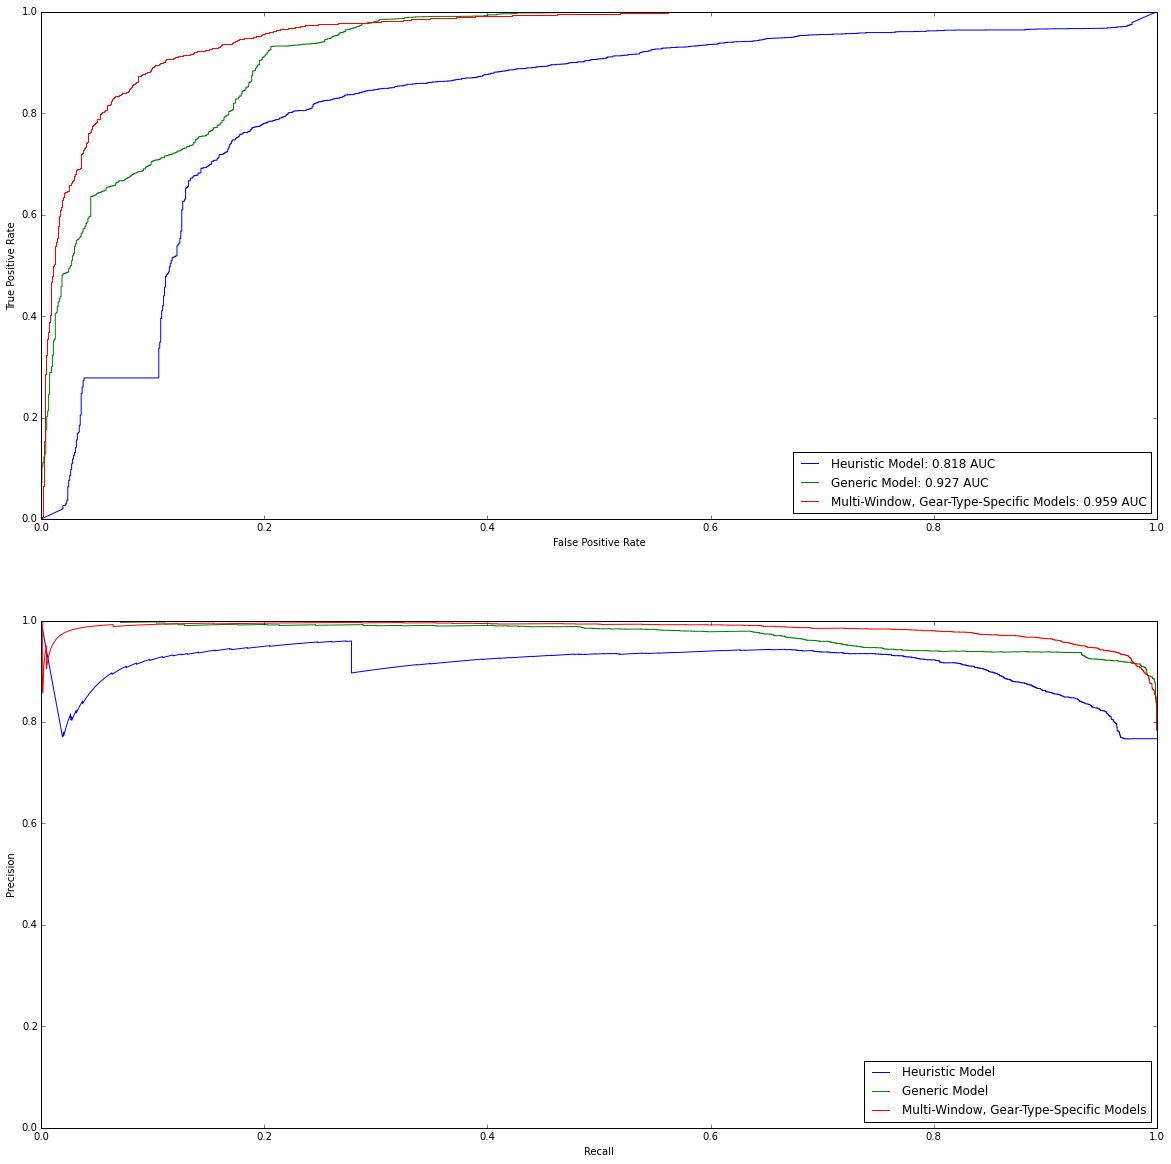

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|0.70|0.80|0.74|
|Generic Model|0.72|0.84|0.78|
|Multi-Window, Gear-Type-Specific Models|0.85|0.84|0.85|

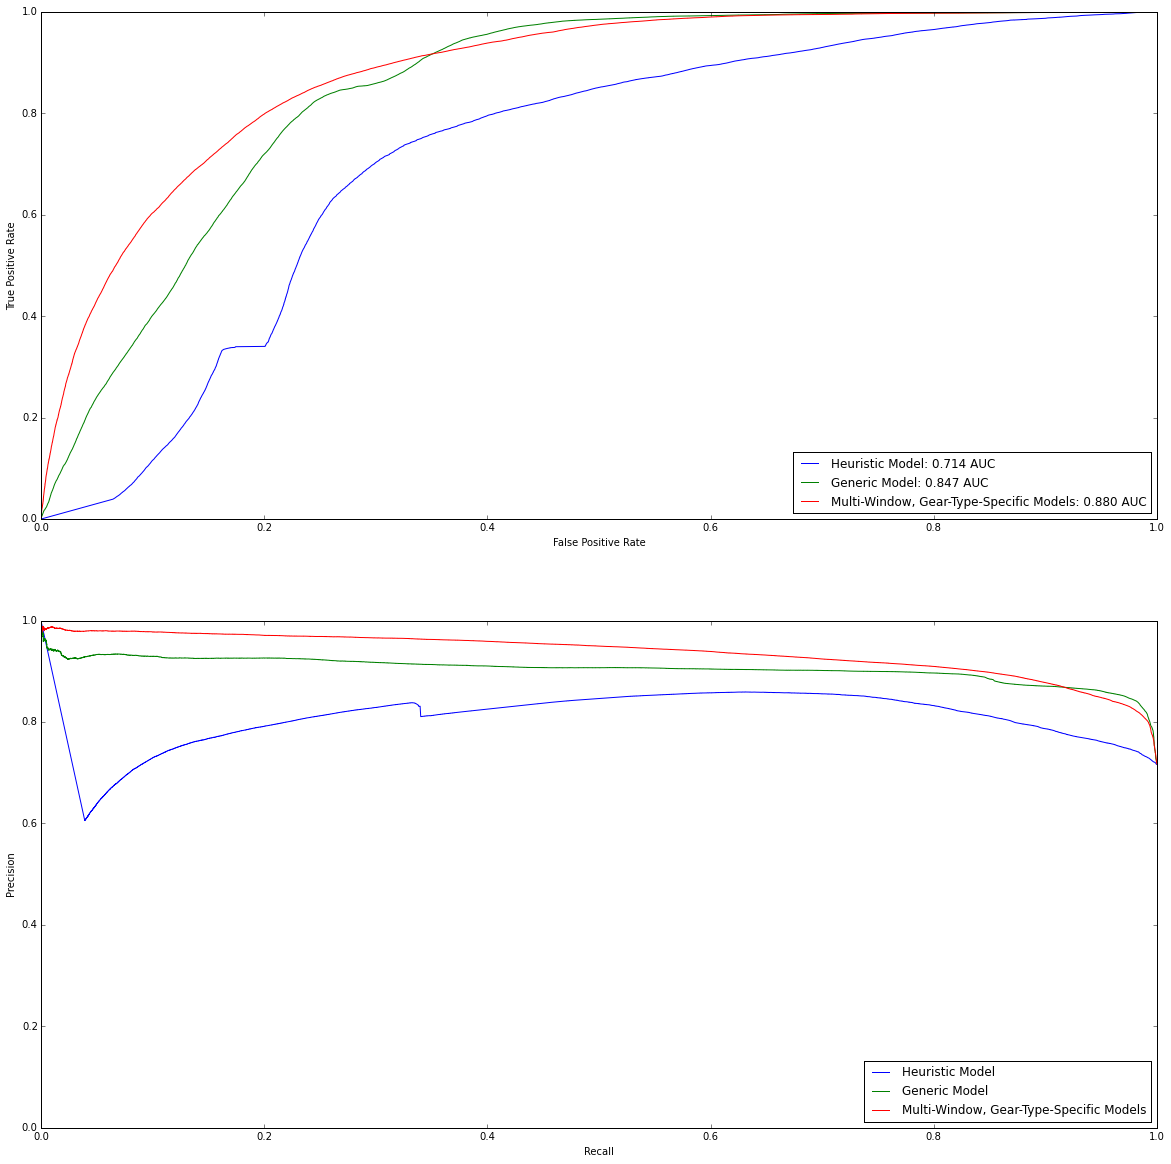

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|0.52|0.55|0.54|
|Generic Model|0.52|0.53|0.52|
|Multi-Window, Gear-Type-Specific Models|0.67|0.55|0.60|

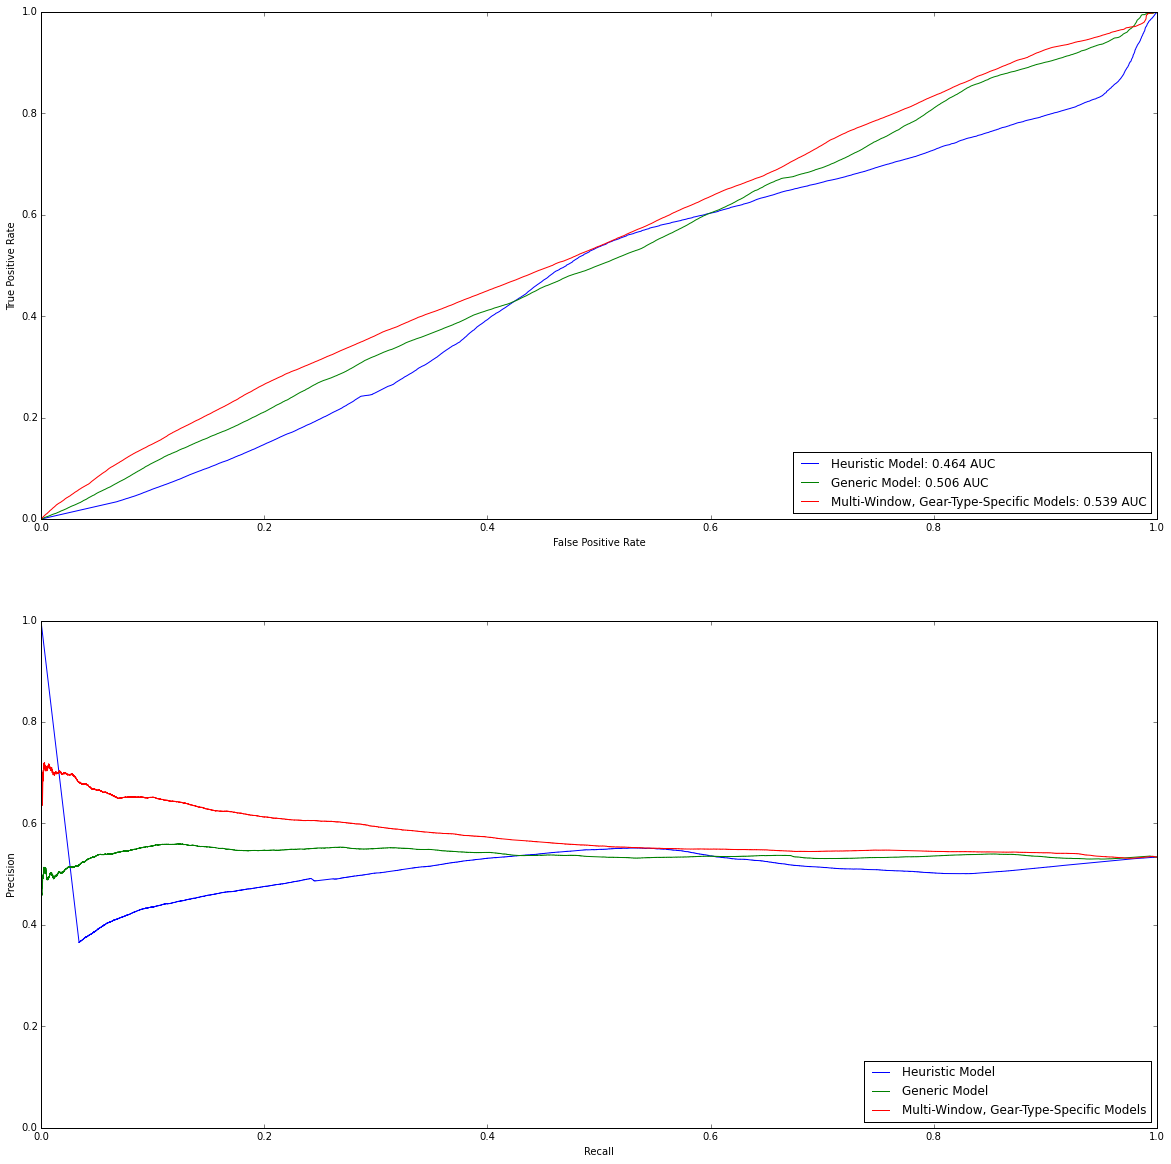

In [47]:
for gear in ['purse_seine', 'purse_seine crowd 2', 
             'trawler', 'trawler crowd 2', 
             'longliner', 'longliner crowd', 'longliner crowd 2']:
    X_test = test_data[gear]

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
        
    trained_models = [(name, train_model_on_data(mdl, X_train[gear])) for (name, mdl, X_train) in untrained_models]
    
    predictions = []
    for name, mdl in trained_models:
        predictions.append((name, (mdl.predict_proba(X_test)[:,1] > 0.5), X_test['classification'] > 0.5))

    lines = ["|Model|Recall|Precision|F1-Score|",
         "|-----|------|---------|--------|"]
    for name, pred, actual in predictions:
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                            metrics.recall_score(actual, pred),
                                            metrics.precision_score(actual, pred), 
                                            metrics.f1_score(actual, pred)))

    display(Markdown('\n'.join(lines)))

    compare_models(trained_models, X_test)
    
    display(HTML("<hr/>"))

# Compare Performance Across Datasets

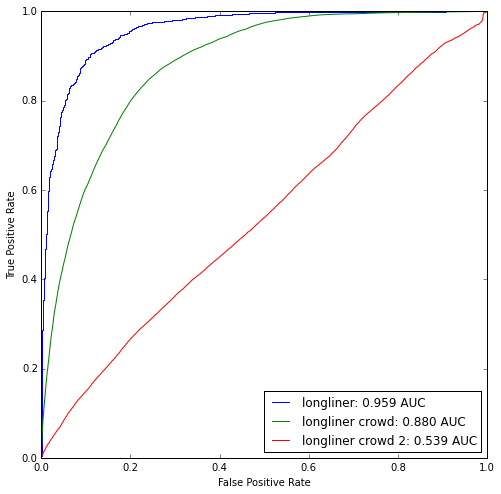

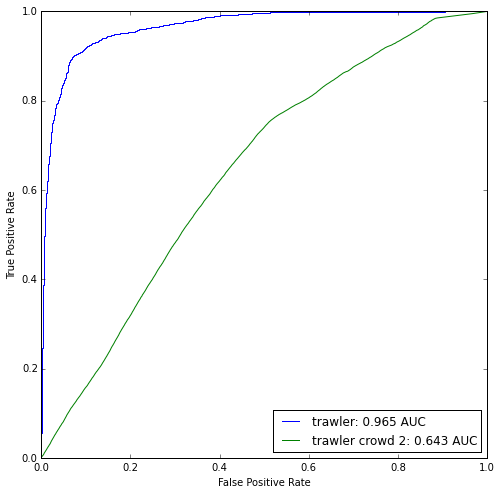

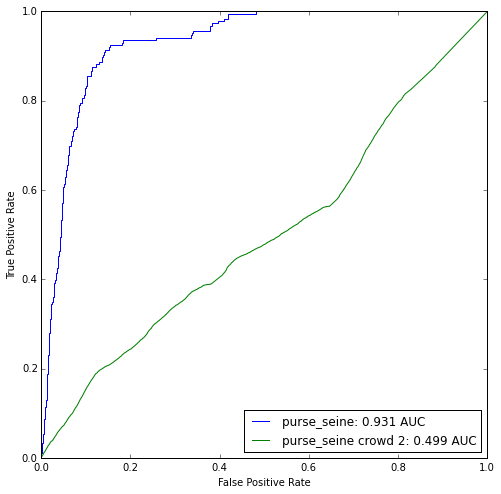

In [48]:

gear_sets = [
    ('Longliner', ["longliner", "longliner crowd", "longliner crowd 2"]),
    ('Trawler', ['trawler', 'trawler crowd 2']),
    ('Purse Seine', ['purse_seine', 'purse_seine crowd 2']),    
]


for gear, test_sets in gear_sets:
    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
    name, mdl, training_data = untrained_models[-1]
    display(HTML("<h3>{}</h3>".format(name)))
    mdl = train_model_on_data(mdl, training_data[test_sets[-1]])
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    for tset in test_sets:
        X_test = test_data[tset]
        
        is_fishy = utils.is_fishy(X_test)
        score = mdl.predict_proba(X_test)[:,1]
        fpr, tpr, _ = (metrics.roc_curve(is_fishy, score))
        auc = metrics.auc(fpr, tpr)
        ax.plot(fpr, tpr, label='{0}: {1:.3f} AUC'.format(tset, auc))

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    ax.set_ylim(0, 1)
    plt.show()
    
    display(HTML("<hr/>"))